# HW4 – Statistics and Data Analysis
## Differential Gene Expression in Acute Myocardial Infraction 

Ido Hadanny
ID 034537969

Ilia Kohanovsky
ID 322156159

## 1.	Introduction
Gene expression describes the process in which genes that are coded in the DNA of living organisms are transcribed into mRNA.  
This is part of the bigger process in which genes are being copied (transcribed), processed, translated and modified into the final product, usually a protein.  
Gene expression profiling measures the levels at which mRNA molecules pertaining to the genes profiled are observed in a sample.  

In this exercise, we will perform guided analysis, comparing expression profiles of circulating endothelial cells (CECs) in patients with acute myocardial infraction to CECs in healthy controls.  
A comparison of two sample classes. You will then select one more gene expression dataset and perform your own analysis there.  


## 2.	The Data Set
The data set was taken from:  
1)	Dataset record in NCBI:  
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE66360  

2)	Published paper: Muse et al, Sci Rep 2017   
https://www.nature.com/articles/s41598-017-12166-0  

3)  Dowload:  
We extracted the data matrix and provide it as a separate csv attachment   
https://drive.google.com/file/d/1-mu1J2wnlDIVNzoCXw20jJQ9r-h1jGrZ/view) 

<br>

The csv file needs to be pre-processed before moving to the main analysis steps.  
Some information should be removed but make sure that you keep all information that is important for the analysis.  
The paper describes a study that seeks to develop an expression-based signature that can detect AMI in patients in a non-invasive manner, by profiling CECs. 


In [1]:
import pandas as pd
import math
from scipy.stats import *
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('AMI_GSE66360_series_matrix_no_metadata.csv')
data = data[1:]
data = data.set_index('Class')

/Users/adsurbum/anaconda2/envs/py371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,H,H.1,H.2,H.3,H.4,H.5,H.6,H.7,H.8,H.9,...,M.39,M.40,M.41,M.42,M.43,M.44,M.45,M.46,M.47,M.48
Class,,,,,,,,,,,,,,,,,,,,,
1007_s_at,5.866377893,4.948736331,5.148384393,5.064418945,5.017832878,5.116153518,5.431328058,5.235270857,5.773528455,6.016415473,...,5.419481538,5.057716465,5.996493392,5.343132759,5.558892254,6.472517225,5.678815851,5.653286378,6.013841046,5.465333944
1053_at,8.22579012,7.525865369,7.764636529,7.198461482,7.831450258,7.203591859,7.694550756,7.760259212,8.279814404,7.580840863,...,7.226347747,7.105537863,5.354105386,8.271499725,5.96334574,8.261421952,6.925752665,7.918424183,7.442701377,9.225221352
117_at,6.17973231,6.628137025,5.859151477,5.974135101,6.793079158,6.43522914,6.320546126,6.48359047,6.387779205,6.307065808,...,6.789500767,7.441939912,7.026928573,6.003972814,7.474325713,6.367759272,6.835755831,7.577034915,7.147417202,6.48112813
121_at,6.179477974,6.58288903,6.602134766,6.545904723,5.911542321,6.28542026,6.562315839,6.345887555,6.27280582,5.971847425,...,6.513436777,6.317522639,7.413453376,6.809103167,5.949091368,6.440978114,6.955883278,6.499215058,6.587065112,6.897590966
1255_g_at,2.792047952,2.69571445,2.580181122,2.712123845,2.723686912,2.70668403,2.674746672,2.635149735,2.696649177,2.802862883,...,2.924657514,2.714103313,3.635944854,2.710943641,2.979380765,3.73013912,2.914867562,3.013901455,2.729319786,3.151449425


## 3.	Analysis

### a. High level description of the data and some pre-processing
1. How many genes profiled? 
2. How many samples (subjects/patients) in total?
3. How many samples in each class?
4. If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [4]:
data.shape

(54675, 99)

55K genes were profiled for 99 patients

In [5]:
healthy = [c for c in data.columns if c.startswith('H')]
ami = [c for c in data.columns if c.startswith('M')]
len(healthy), len(ami)

(50, 49)

50 healthy patients vs. 49 AMI patients

In [6]:
sum(~data.T.isnull().any())

54628

In [7]:
data = data[~data.T.isnull().any()]
data.shape

(54628, 99)

In [8]:
54675-54628

47

47 genes removed as they had null values

### b. WRS for differential expression (DE)
1. Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?
2. Denote this sum of ranks by RS(g). What is the minimal value, m, that RS(g) can take?
3. Under the null model, what is the probability of RS(g) = m? (provide a formula for this and explain it)
4. Under the null model, what is the probability of RS(g) = m+1? what is the probability of RS(g) = m+2? (provide formulas and explain them)
5. Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up)

In [9]:
E = 49*(99+1)/2
m = 49*(49+1)/2
E, m

(2450.0, 1225.0)

$E(RS_g)=2450$

$min(RS_g)=1225$

In [10]:
1/(math.factorial(99)/(math.factorial(49)*math.factorial(50)))

1.9823306042836678e-29

$P(RS_g=m)=P(RS_g=m+1)=2*10^{-29}$

$P(RS_g=m+2)=4*10^{-29}$

this is because under the null model there is no difference between the 2 classes and every permutation is equally likely. Note that we don't care about the internal ordering of the patients within each class.

When $RS_g=m$ there is only one possible permutation that satistfy the sum rank: {1,2,..,49}.

When $RS_g=m+1$ there is also only one possible permutation that satistfy the rank: {1,2,..,47,48,50}.

When $RS_g=m+2$ there are two possible permutation that satistfy the rank: {1,2,..,47,48,51} and {1,2,..,46,47,49,50}.

In [11]:
sd = (49*(99-49)*(99+1)/12)**0.5
RS = [E+sd*ranksums(a,h).statistic for a, h in zip(
    data[ami].values.astype(float), data[healthy].values.astype(float))]

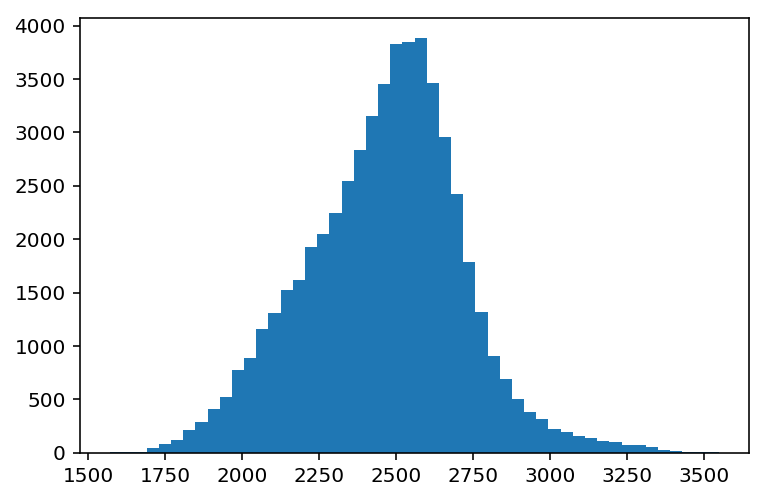

In [12]:
plt.hist(RS, bins=50)
plt.show()

### c. Differential Expression
The purpose is to determine the statistical significance of differential expression (DE) observed for each gene in H vs M.  
Evaluate the DE in both one-sided directions for every gene, using both Student t-test and WRS test.   
Report the number of genes overexpressed in M vs H at a p-value better (≤) than 0.05 and separately genes underexpressed in M vs H at a p-value of 0.05. For both directions use both a Student t-test and a WRS test.  

In [19]:
wrs = [ranksums(a,h) for a, h in zip(data[ami].values.astype(float),
                                     data[healthy].values.astype(float))]
wrs_over = [w for w in wrs if w.statistic>0 and w.pvalue/2<0.05]
wrs_under = [w for w in wrs if w.statistic<0 and w.pvalue/2<0.05]
print('WRS test #overexpressed:',len(wrs_over))
print('WRS test #underexpressed:',len(wrs_under))

WRS test #overexpressed: 9019
WRS test #underexpressed: 9476


In [116]:
ttest = [ttest_ind(a,h) for a, h in zip(data[ami].values.astype(float),
                                        data[healthy].values.astype(float))]
ttest_over = [w for w in ttest if w.statistic>0 and w.pvalue/2<0.05]
ttest_under = [w for w in ttest if w.statistic<0 and w.pvalue/2<0.05]
print('Student t-test #overexpressed:',len(ttest_over))
print('Student t-test #underexpressed:',len(ttest_under))

Student t-test #overexpressed: 7067
Student t-test #underexpressed: 7467


### d. Correlations
Select the 60 most significant genes from each one of the one-sided WRS DE lists you computed in 3c. Generate a set of 120 genes, D, which is the union of the above two sets.  
Compute Spearman rho correlations in all pairs within D (120 choose 2 numbers).   

1. What can you report about co-expression of genes in D (co-expression is inferred from the correlation of the expression levels of genes, across a set of samples)? Do we observe any significant co-expression? If so how many pairs, etc.
2. What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D? 
3. Perform the above steps on the same set D, but restrict attention only to samples labeled M. What do you see now? Can you explain this?

In [52]:
#calculate D
dwrs = pd.DataFrame(wrs)

smallest = dwrs[dwrs.statistic>0].nsmallest(60,'pvalue')
over = data.iloc[smallest.index]
smallest = dwrs[dwrs.statistic<0].nsmallest(60,'pvalue')
under = data.iloc[smallest.index]

D = over.append(under)

In [30]:
corr = D.transpose().astype(float).corr(method='spearman')
del corr.index.name

In [31]:
def flatten_corr(corr):
    sig_corr = corr.stack().reset_index()
    sig_corr.columns = ['gen_a', 'gen_b', 'my_corr']
    sig_corr = sig_corr.query('gen_a < gen_b').sort_values('my_corr')
    return sig_corr
def p_value(row):
    a = D.loc[row['gen_a']].values
    b = D.loc[row['gen_b']].values
    return spearmanr(a,b)[1]

sigcorr = flatten_corr(corr)
sigcorr['p_value'] = sigcorr.apply(p_value,axis=1)
print('Number of pairs:', len(sigcorr))


Number of pairs: 7140


In [32]:
sigcorr = sigcorr[sigcorr['p_value']<0.05]
print('pairs with correlation p_value<0.05:',len(sigcorr))

pairs with correlation p_value<0.05: 6768


In [27]:
print('significant correlations with abs correlation >0.6: ',len(sigcorr[abs(sigcorr['my_corr']) > 0.6]))
print('significant correlations with positive correlation >0.6: ',len(sigcorr[sigcorr['my_corr'] > 0.6]))
print('significant correlations with positive correlation >0.7: ',len(sigcorr[sigcorr['my_corr'] > 0.7]))
print('significant correlations with positive correlation >0.8: ',len(sigcorr[sigcorr['my_corr'] > 0.8]))
print('significant correlations with positive correlation >0.9: ',len(sigcorr[sigcorr['my_corr'] > 0.9]))

significant correlations with abs correlation >0.6:  1971
significant correlations with positive correlation >0.6:  1915
significant correlations with positive correlation >0.7:  891
significant correlations with positive correlation >0.8:  188
significant correlations with positive correlation >0.9:  12


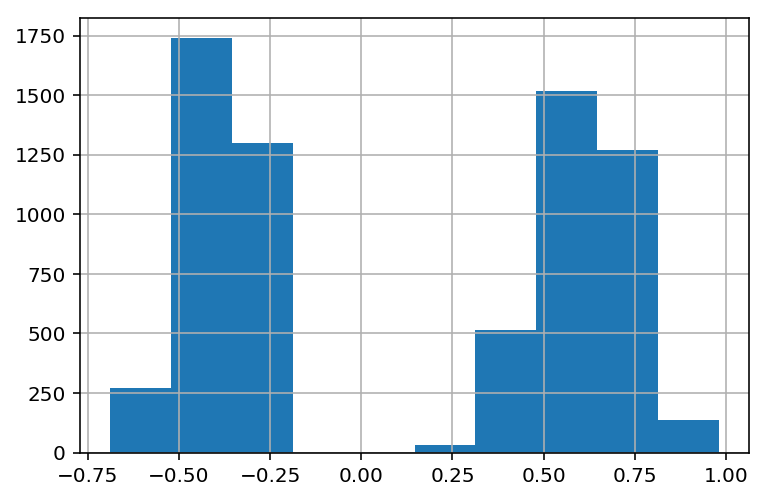

In [355]:
sigcorr['my_corr'].hist()

In [342]:
print('top 10 positive correlations:')
sigcorr.nlargest(10,'my_corr')

top 10 positive correlations:


,gen_a,gen_b,my_corr,p_value
7746,218805_at,64064_at,0.980779,1.188865e-70
3530,204620_s_at,221731_x_at,0.955733,2.455596e-53
241,204622_x_at,216248_s_at,0.946320,2.257105e-49
12673,1552320_a_at,1552321_a_at,0.944848,1.586870e-21
6150,201473_at,201531_at,0.926837,4.709451e-43
6261,202497_x_at,216236_s_at,0.925863,8.735132e-43
2779,203821_at,38037_at,0.924774,1.725242e-42
10426,221937_at,64418_at,0.923772,3.198986e-42
485,203887_s_at,203888_at,0.921781,1.064874e-41
9674,201998_at,202741_at,0.909524,9.214875e-39


In [343]:
print('top 10 negative correlations:')
sigcorr.nsmallest(10,'my_corr')

top 10 negative correlations:


,gen_a,gen_b,my_corr,p_value
2143,204621_s_at,223377_x_at,-0.688487,3.404342e-15
2147,204621_s_at,235304_at,-0.685828,4.780699e-15
223,216248_s_at,223377_x_at,-0.680989,8.786252e-15
180,216248_s_at,226423_at,-0.676388,1.550675e-14
300,204622_x_at,226423_at,-0.675906,1.644862e-14
2134,204621_s_at,233852_at,-0.660596,1.010631e-13
2107,204621_s_at,206991_s_at,-0.658596,1.271175e-13
5516,1568830_at,219532_at,-0.657823,1.388383e-13
343,204622_x_at,223377_x_at,-0.656574,1.600217e-13
5506,1568830_at,64418_at,-0.654978,1.916569e-13


Conclusion:
We have significant co-expression for a lot of gene pairs: 891 with correlation >0.7 (when 7140 is all possible pair combinations)

There's no exist so significant negative correlation between genes

2. What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D? 

Dissadvantages: execution time; multiple testing error rate higher because more comparisons; we are interesting more in correlations between target genes - those that associated with the AMI

Advantages: correlations for more genes can be found. Maybe we missed some associated to AMI genes that we can find by high correlation with another gene that is associated with AMI

**3** Perform the above steps on the same set D, but restrict attention only to samples labeled M. What do you see now? Can you explain this?

In [61]:
#calculate D
dwrs = pd.DataFrame(wrs)
smallest = dwrs[dwrs.statistic>0].nsmallest(60,'pvalue')
over = data.iloc[smallest.index]
smallest = dwrs[dwrs.statistic<0].nsmallest(60,'pvalue')
under = data.iloc[smallest.index]
D = over.append(under)
D = D[ami]

corr = D.transpose().astype(float).corr(method='spearman')
del corr.index.name
sigcorr = flatten_corr(corr)
sigcorr['p_value'] = sigcorr.apply(p_value,axis=1)
print('Number of pairs:', len(sigcorr))
sigcorr = sigcorr[sigcorr['p_value']<0.05]
print('pairs with correlation p_value<0.05:',len(sigcorr))

print('significant correlations with abs correlation >0.6: ',len(sigcorr[abs(sigcorr['my_corr']) > 0.6]))
print('significant correlations with positive correlation >0.6: ',len(sigcorr[sigcorr['my_corr'] > 0.6]))
print('significant correlations with positive correlation >0.7: ',len(sigcorr[sigcorr['my_corr'] > 0.7]))
print('significant correlations with positive correlation >0.8: ',len(sigcorr[sigcorr['my_corr'] > 0.8]))
print('significant correlations with positive correlation >0.9: ',len(sigcorr[sigcorr['my_corr'] > 0.9]))

Number of pairs: 7140
pairs with correlation p_value<0.05: 3294
significant correlations with abs correlation >0.6:  1005
significant correlations with positive correlation >0.6:  1004
significant correlations with positive correlation >0.7:  477
significant correlations with positive correlation >0.8:  132
significant correlations with positive correlation >0.9:  11


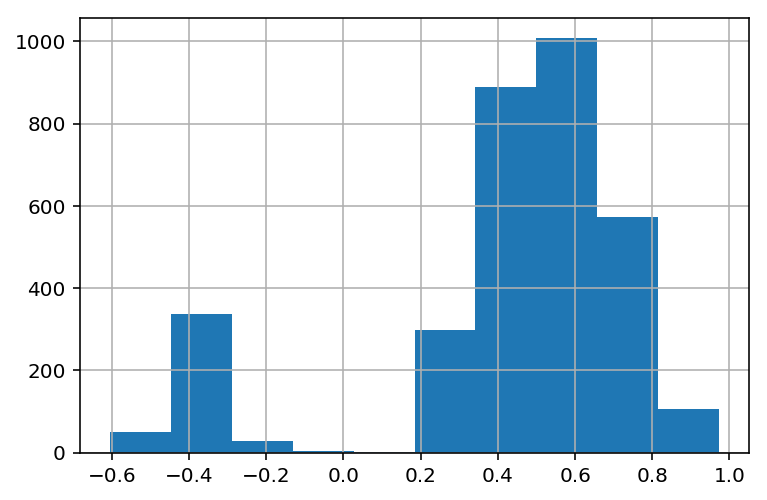

In [62]:
sigcorr['my_corr'].hist()

In [63]:
print('top 10 positive correlations:')
sigcorr.nlargest(10,'my_corr')

top 10 positive correlations:


,gen_a,gen_b,my_corr,p_value
10790,204620_s_at,221731_x_at,0.972755,1.731798e-31
7501,204622_x_at,216248_s_at,0.949694,2.439718e-25
7745,203887_s_at,203888_at,0.944082,2.753075e-24
12556,211924_s_at,222934_s_at,0.937959,2.956065e-23
5413,1552320_a_at,1552321_a_at,0.932959,1.728283e-22
13521,202497_x_at,216236_s_at,0.931633,2.698793e-22
10039,203821_at,38037_at,0.931122,3.195811e-22
486,218805_at,64064_at,0.926429,1.427830e-21
12235,201963_at,207275_s_at,0.923163,3.819684e-21
9670,205403_at,211372_s_at,0.913061,6.215500e-20


In [65]:
print('top 10 negative correlations:')
sigcorr.nsmallest(10,'my_corr')

top 10 negative correlations:


,gen_a,gen_b,my_corr,p_value
14087,202464_s_at,235304_at,-0.604388,0.000004
7483,204622_x_at,223377_x_at,-0.597449,0.000006
7466,204622_x_at,221937_at,-0.590714,0.000008
7363,216248_s_at,223377_x_at,-0.578571,0.000013
7474,204622_x_at,233852_at,-0.567347,0.000021
9287,204621_s_at,235304_at,-0.567143,0.000021
7493,204622_x_at,219494_at,-0.563367,0.000025
7482,204622_x_at,213405_at,-0.551020,0.000041
9293,204621_s_at,219494_at,-0.536939,0.000070
7499,204622_x_at,241582_at,-0.532041,0.000083


We got much less significant correlations. 

Probably it happens because H and M patients have significantly different expression levels, and if genes correlates we see significant changes for H and M for both genes. And it contribute to correlation significance. 

### e. Plots and Conclusions of the DE and correlation analysis
1. Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c.   
    State, for each comparison, the number of genes, k, at which we observe:  
	FDR = 0.1  
	FDR = 0.05  
	FDR = 0.001   
    If these events are not observed at any k, then make that statement.  
2. What can you say about the difference in results obtained in WRS vs those obtained by Student t-test?
3. Select any 3 differentially expressed genes, from D (which was defined in 3d), and produce a graphical representation of their expression patterns that demonstrates the observed DE.

### f. Heatmap
Draw a heatmap representation of the expression values of the genes in D (from 3d), across the entire cohort (all samples).   Order the genes and the samples to produce the maximal visual effect.  



In [ ]:
# def corr_heat_map(corr):
#     ax = sns.heatmap(
#         corr, 
#         vmin=-1, vmax=1, center=0,
#         cmap=sns.diverging_palette(20, 220, n=200),
#         square=True
#     )
#     ax.set_xticklabels(
#         ax.get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     );
# import seaborn as sns
# corr_heat_map(corr)
